## Imports

In [1]:
pip install grad-cam

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, time, math, random, sys
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import v2 as T
from torchvision.models import (
    convnext_small, ConvNeXt_Small_Weights,
    resnet101, ResNet101_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights,
)



## Config

In [3]:
@dataclass
class CFG:
    data_root: str = "./stanford_cars"
    num_classes: int = 196  # Stanford Cars has 196 classes
    img_size: int = 320

    use_bbox: bool = True  # set True to train/eval on bbox crops

    epochs: int = 20
    batch_size: int = 40
    num_workers: int = 4

    lr: float = 3e-4
    weight_decay: float = 0.1
    label_smoothing: float = 0.1

    use_amp: bool = True
    grad_clip_norm: float = 1.0

    # cosine schedule
    warmup_epochs: int = 1
    min_lr: float = 1e-6

    seed: int = 42
    save_dir: str = "./checkpoints"
    run_name: str = "convnext_small_stanfordcars_imagenet1k"
    model_name: str = "ConvNeXt_s"

cfg = CFG()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

os.makedirs(cfg.save_dir, exist_ok=True)


Device: cuda


In [4]:
import os

print("Data root exists:", os.path.exists(cfg.data_root))
print("Save dir exists:", os.path.exists(cfg.save_dir))
print("Data contents:", os.listdir(cfg.data_root)[:5])


Data root exists: True
Save dir exists: True
Data contents: ['anno_test.csv', 'anno_train.csv', 'car_data', 'names.csv']


In [5]:
from data_utils import load_car_annotations
_, test_df, id_to_name = load_car_annotations(cfg.data_root)
test_df.head()

train rows: 8144 with paths: 8144
test rows: 8041 with paths: 8041


file_name   x1   y1   x2   y2  class_id  \
0  00001.jpg   30   52  246  147       181   
1  00002.jpg  100   19  576  203       103   
2  00003.jpg   51  105  968  659       145   
3  00004.jpg   67   84  581  407       187   
4  00005.jpg  140  151  593  339       185   

                            class_name  \
0              Suzuki Aerio Sedan 2007   
1  Ferrari 458 Italia Convertible 2012   
2                Jeep Patriot SUV 2012   
3              Toyota Camry Sedan 2012   
4             Tesla Model S Sedan 2012   

                                            filepath  
0  stanford_cars\car_data\car_data\test\Suzuki Ae...  
1  stanford_cars\car_data\car_data\test\Ferrari 4...  
2  stanford_cars\car_data\car_data\test\Jeep Patr...  
3  stanford_cars\car_data\car_data\test\Toyota Ca...  
4  stanford_cars\car_data\car_data\test\Tesla Mod...

## Run Inference on Train and Test Sets


=== Eval: convnext_small_224 ===
Test - loss: 1.1341 | top1: 0.9309 | top5: 0.9894 | inference_time: 33.81s

=== Eval: convnext_small_320 ===
Test - loss: 1.0808 | top1: 0.9436 | top5: 0.9910 | inference_time: 33.97s

=== Eval: resnet101_224 ===
Test - loss: 1.2792 | top1: 0.8984 | top5: 0.9804 | inference_time: 30.76s

=== Eval: resnet101_320 ===
Test - loss: 1.1862 | top1: 0.9295 | top5: 0.9892 | inference_time: 33.41s

=== Eval: efficientnet_v2_m_224 ===
Test - loss: 1.1571 | top1: 0.9152 | top5: 0.9859 | inference_time: 30.76s

=== Eval: efficientnet_v2_m_320 ===
Test - loss: 1.0817 | top1: 0.9403 | top5: 0.9887 | inference_time: 33.85s

=== Plots: convnext_small_224 ===


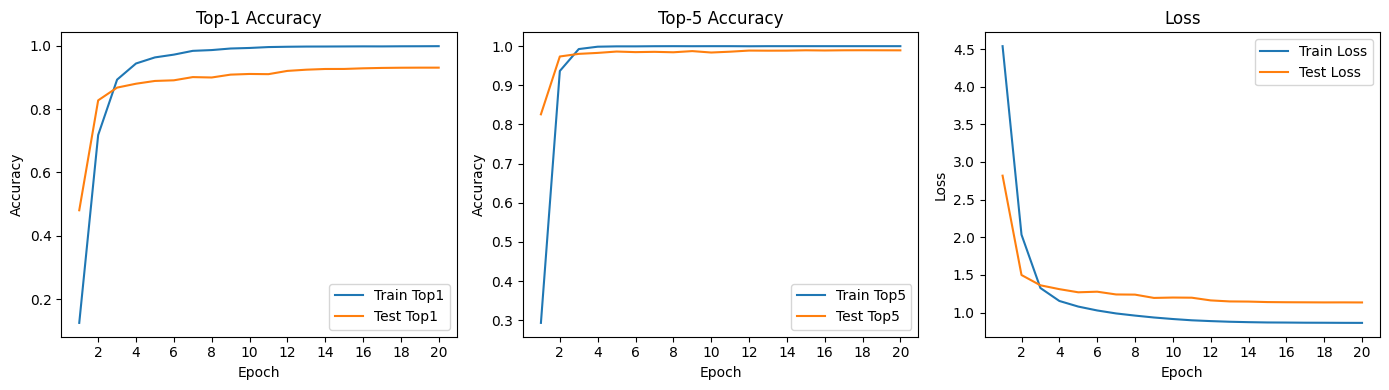


=== Plots: convnext_small_320 ===


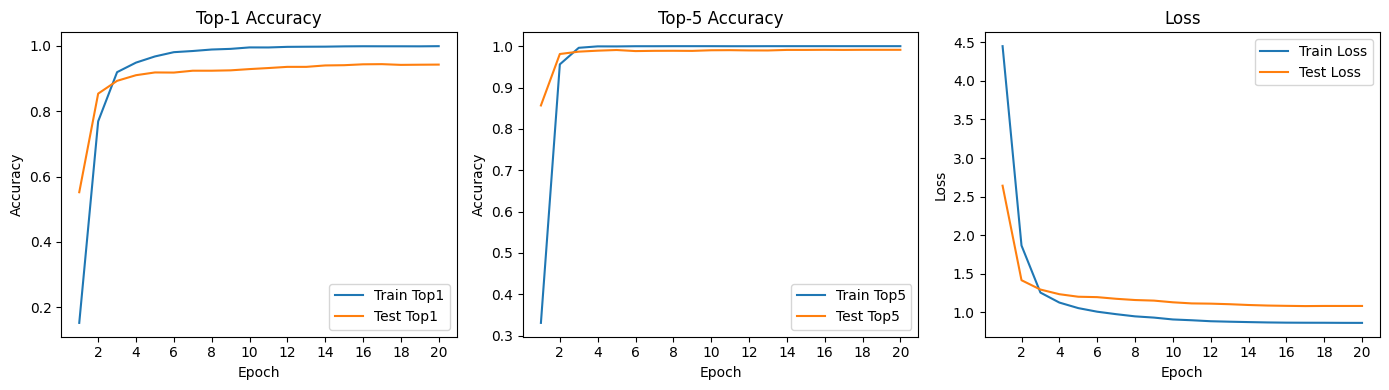


=== Plots: resnet101_224 ===


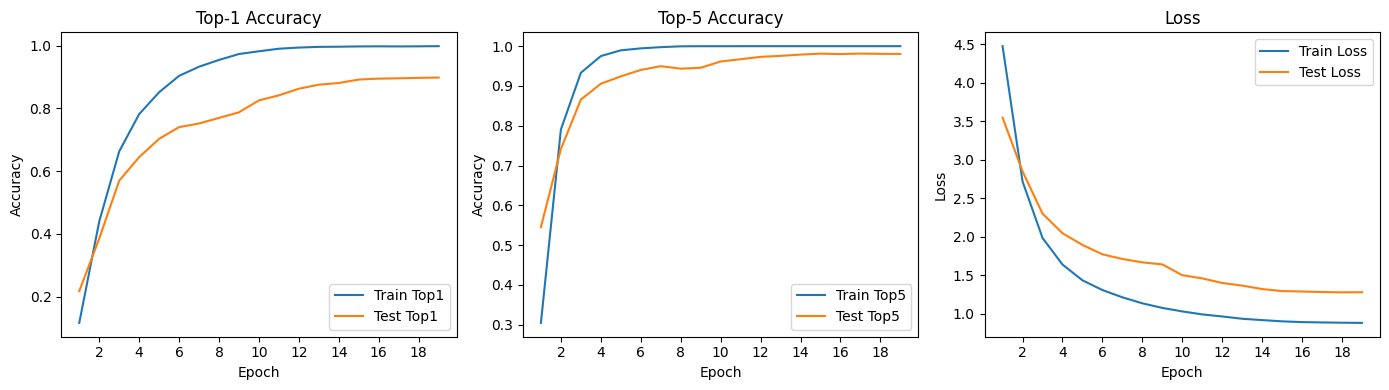


=== Plots: resnet101_320 ===


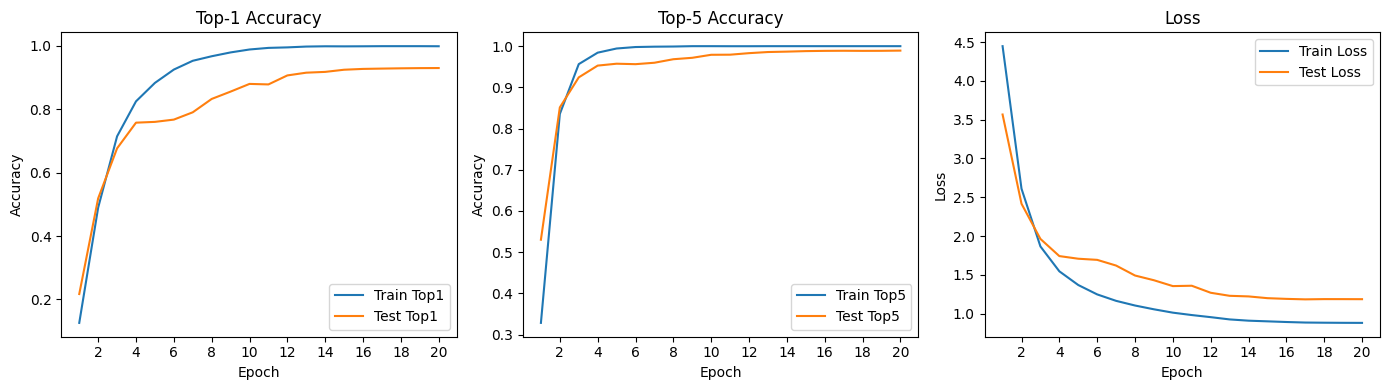


=== Plots: efficientnet_v2_m_224 ===


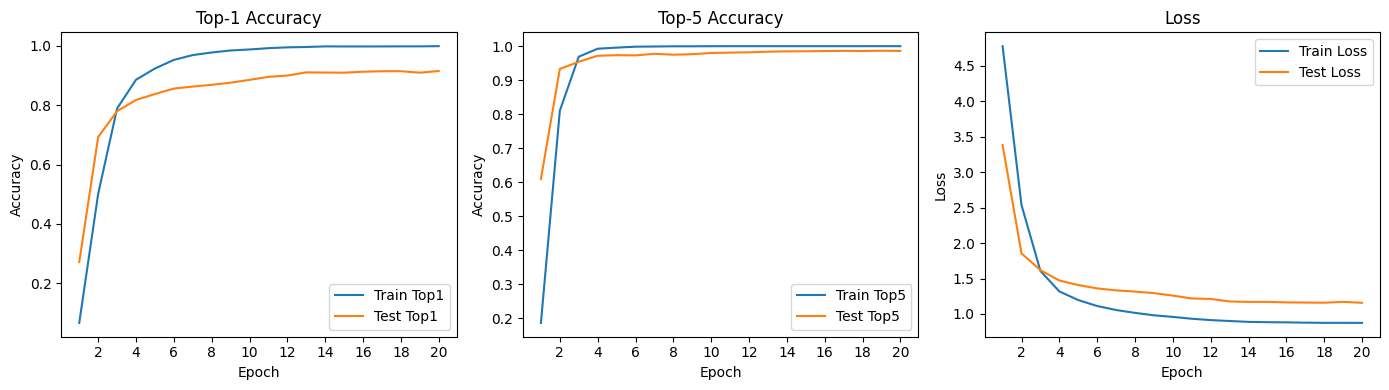


=== Plots: efficientnet_v2_m_320 ===


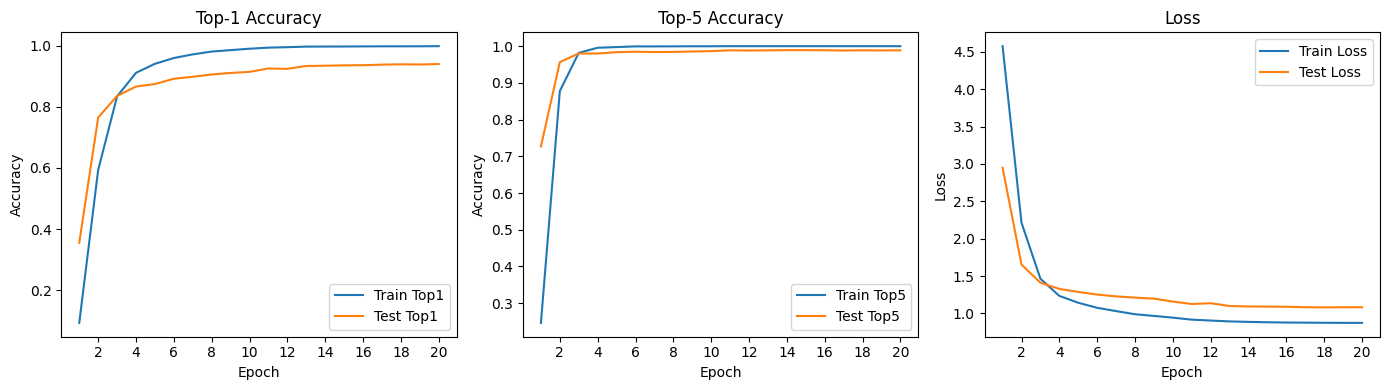

In [10]:
# Run inference once per model and cache results (metrics + history + preds)
import gc

from data_utils import df_to_arrays, get_mean_std_from_weights
from cars_dataset import CarsCsvDataset
from train_utils import evaluate, plot_history

def build_test_transforms(img_size, weights):
    mean, std = get_mean_std_from_weights(weights)
    test_tfms = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=mean, std=std),
    ])
    return test_tfms


def build_test_loader(test_files, test_boxes, test_labels, test_tfms):
    test_ds = CarsCsvDataset(
        test_files, test_boxes, test_labels, transform=test_tfms,
        crop_mode="square_from_full", square_margin=0.10
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    return test_loader


def build_model(model_key, weights):
    if model_key == "convnext_small":
        model = convnext_small(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, cfg.num_classes)
    elif model_key == "resnet101":
        model = resnet101(weights=weights)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, cfg.num_classes)
    elif model_key == "efficientnet_v2_m":
        model = efficientnet_v2_m(weights=weights)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, cfg.num_classes)
    else:
        raise ValueError(f"Unknown model_key: {model_key}")

    return model


def run_cached_eval(model_key, weights, img_size, ckpt_prefix):
    run_name = f"{ckpt_prefix}_{img_size}"

    test_tfms = build_test_transforms(img_size, weights)

    # Build test loader (deterministic order)
    test_files, test_boxes, test_labels = df_to_arrays(test_df)
    test_loader = build_test_loader(test_files, test_boxes, test_labels, test_tfms)

    model = build_model(model_key, weights)
    model = model.to(device)

    best_path = os.path.join(cfg.save_dir, f"{run_name}_best.pth")
    ckpt = torch.load(best_path, map_location=device)
    state = ckpt.get("model", ckpt)
    model.load_state_dict(state)
    model.eval()

    # Inference for predictions
    import time
    t0 = time.time()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            logits = model(images)
            preds = logits.argmax(dim=1)
            all_true.append(labels.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    inference_time = time.time() - t0
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    # Metrics using same predictions
    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
    tst_loss, tst_top1, tst_top5 = evaluate(model, test_loader, epoch=0, cfg=cfg, device=device, criterion=criterion)

    # Cache history for plots if present
    history = ckpt.get("history")

    del model, test_loader
    torch.cuda.empty_cache()
    gc.collect()

    return {
        'model_key': model_key,
        'img_size': img_size,
        'run_name': run_name,
        'y_true': y_true,
        'y_pred': y_pred,
        'test_files': test_files,
        'test_boxes': test_boxes,
        'test_labels': test_labels,
        'test_loss': tst_loss,
        'test_top1': tst_top1,
        'test_top5': tst_top5,
        'history': history,
        'inference_time': inference_time,
    }

model_specs = [
    {
        "model_key": "convnext_small",
        "ckpt_prefix": "convnext_small",
        "weights": ConvNeXt_Small_Weights.IMAGENET1K_V1,
    },
    {
        "model_key": "resnet101",
        "ckpt_prefix": "resnet101",
        "weights": ResNet101_Weights.IMAGENET1K_V1,
    },
    {
        "model_key": "efficientnet_v2_m",
        "ckpt_prefix": "efficientnet_v2_m",
        "weights": EfficientNet_V2_M_Weights.IMAGENET1K_V1,
    },
]

resolutions = [224, 320]

inference_cache = {}
for spec in model_specs:
    for res in resolutions:
        key = f"{spec['ckpt_prefix']}_{res}"
        inference_cache[key] = run_cached_eval(
            model_key=spec["model_key"],
            weights=spec["weights"],
            img_size=res,
            ckpt_prefix=spec["ckpt_prefix"],
        )

# Print eval metrics once
for _, res in inference_cache.items():
    print()
    print(f"=== Eval: {res['run_name']} ===")
    print(f"Test - loss: {res['test_loss']:.4f} | top1: {res['test_top1']:.4f} | top5: {res['test_top5']:.4f} | inference_time: {res['inference_time']:.2f}s")

# Plot history once per model (if available)
for _, res in inference_cache.items():
    if res['history']:
        print()
        print(f"=== Plots: {res['run_name']} ===")
        plot_history(res['history'])
    else:
        print(f"No history found for {res['run_name']}.")


In [7]:
# Top-10 most confused pairs
import numpy as np
import pandas as pd

for _, res in inference_cache.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    run_name = res['run_name']

    mask = y_true != y_pred
    pairs = pd.DataFrame({'a': y_true[mask], 'b': y_pred[mask]})
    pairs[['u', 'v']] = np.sort(pairs[['a', 'b']].values, axis=1)

    pair_counts = (
        pairs.groupby(['u', 'v']).size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
    )

    top10 = pair_counts.head(10)
    print(f"\nTop-10 misclassified pairs for {run_name}:")
    for _, row in top10.iterrows():
        u = int(row['u'])
        v = int(row['v'])
        u_name = id_to_name.get(u + 1, str(u))
        v_name = id_to_name.get(v + 1, str(v))
        print(f"{row['count']:>4}  {u_name}  <->  {v_name}")



Top-10 misclassified pairs for convnext_small_224:
  23  Dodge Caliber Wagon 2012  <->  Dodge Caliber Wagon 2007
  21  Chevrolet Express Cargo Van 2007  <->  Chevrolet Express Van 2007
  19  Bentley Continental GT Coupe 2012  <->  Bentley Continental GT Coupe 2007
  15  Chevrolet Express Van 2007  <->  GMC Savana Van 2012
  15  Chevrolet Silverado 2500HD Regular Cab 2012  <->  Chevrolet Silverado 1500 Regular Cab 2012
  14  Audi V8 Sedan 1994  <->  Audi 100 Sedan 1994
  14  Audi TTS Coupe 2012  <->  Audi TT Hatchback 2011
  13  Audi A5 Coupe 2012  <->  Audi S5 Coupe 2012
   9  BMW 6 Series Convertible 2007  <->  BMW M6 Convertible 2010
   9  Audi TT Hatchback 2011  <->  Audi TT RS Coupe 2012

Top-10 misclassified pairs for convnext_small_320:
  22  Dodge Caliber Wagon 2012  <->  Dodge Caliber Wagon 2007
  21  Chevrolet Express Cargo Van 2007  <->  Chevrolet Express Van 2007
  18  Audi TTS Coupe 2012  <->  Audi TT Hatchback 2011
  17  Bentley Continental GT Coupe 2012  <->  Bentley Con

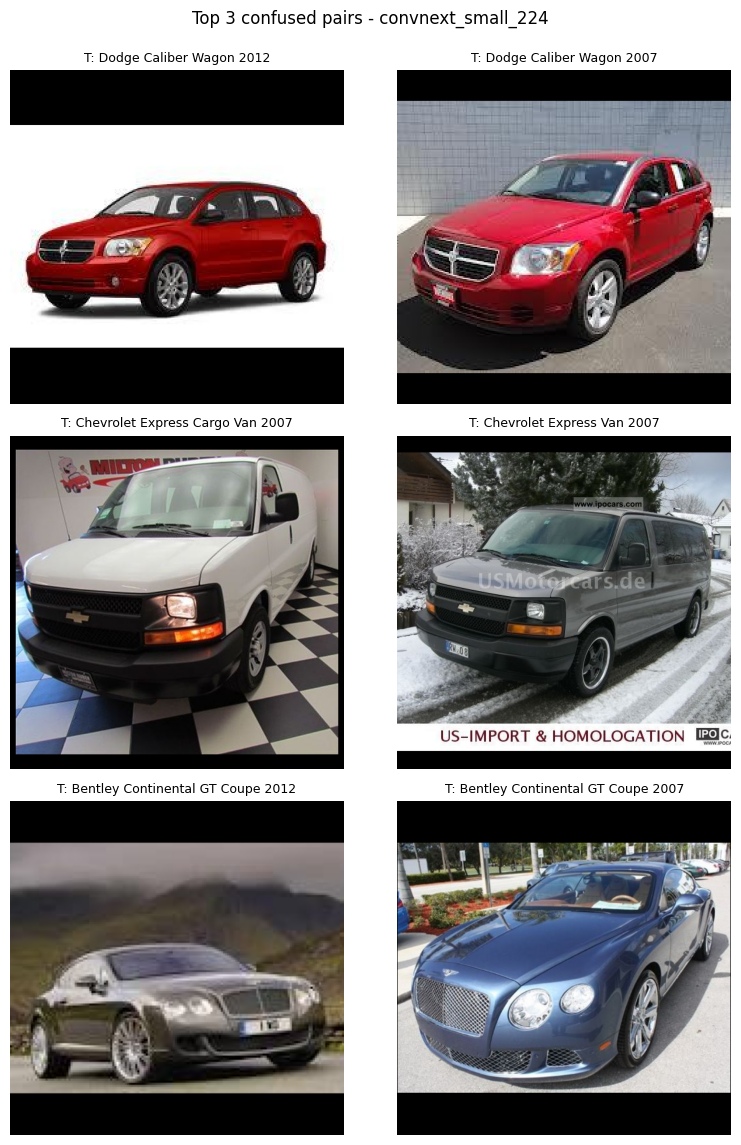

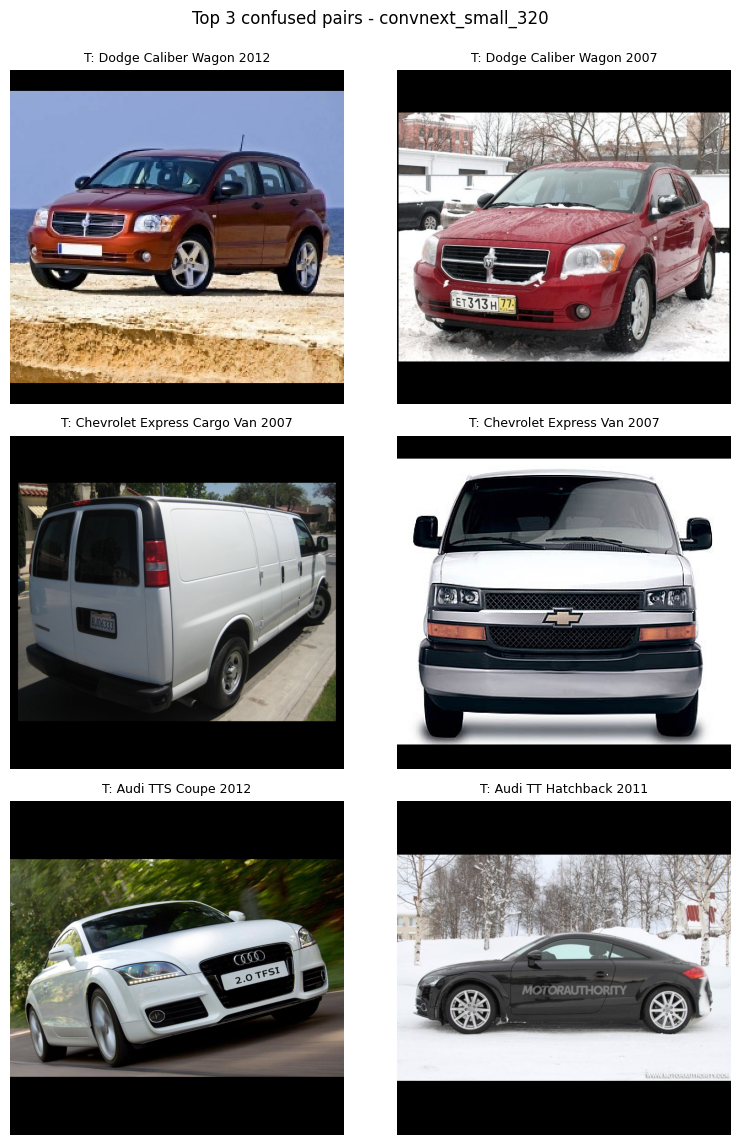

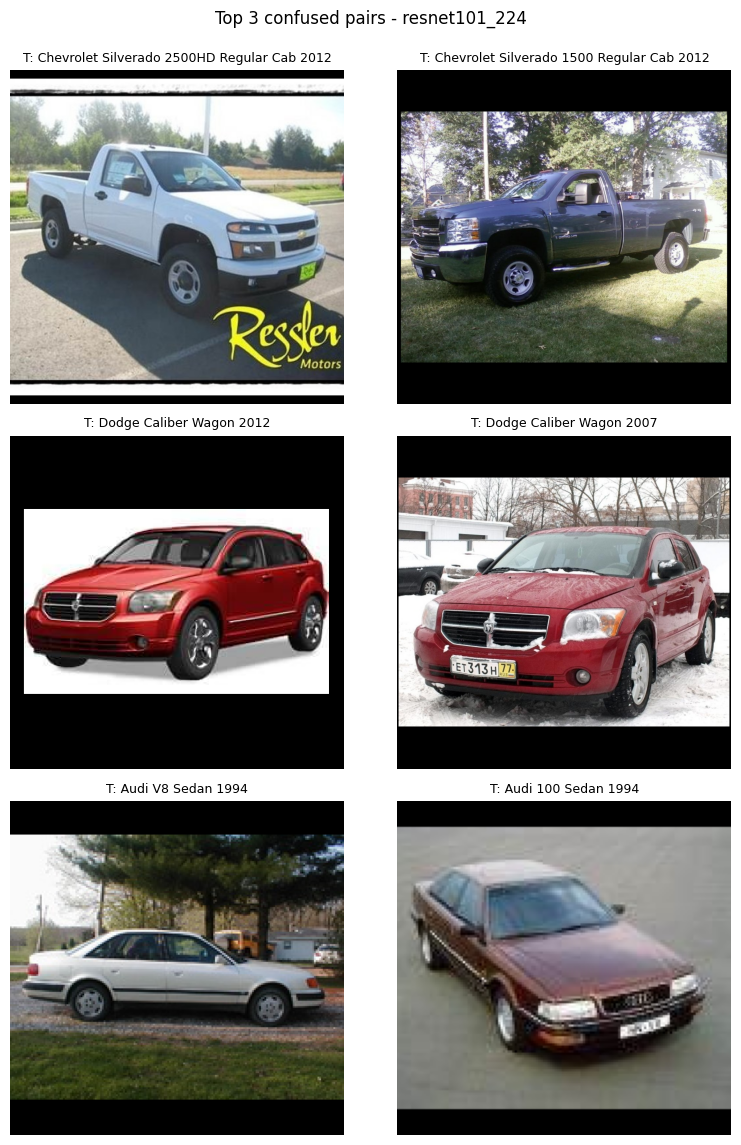

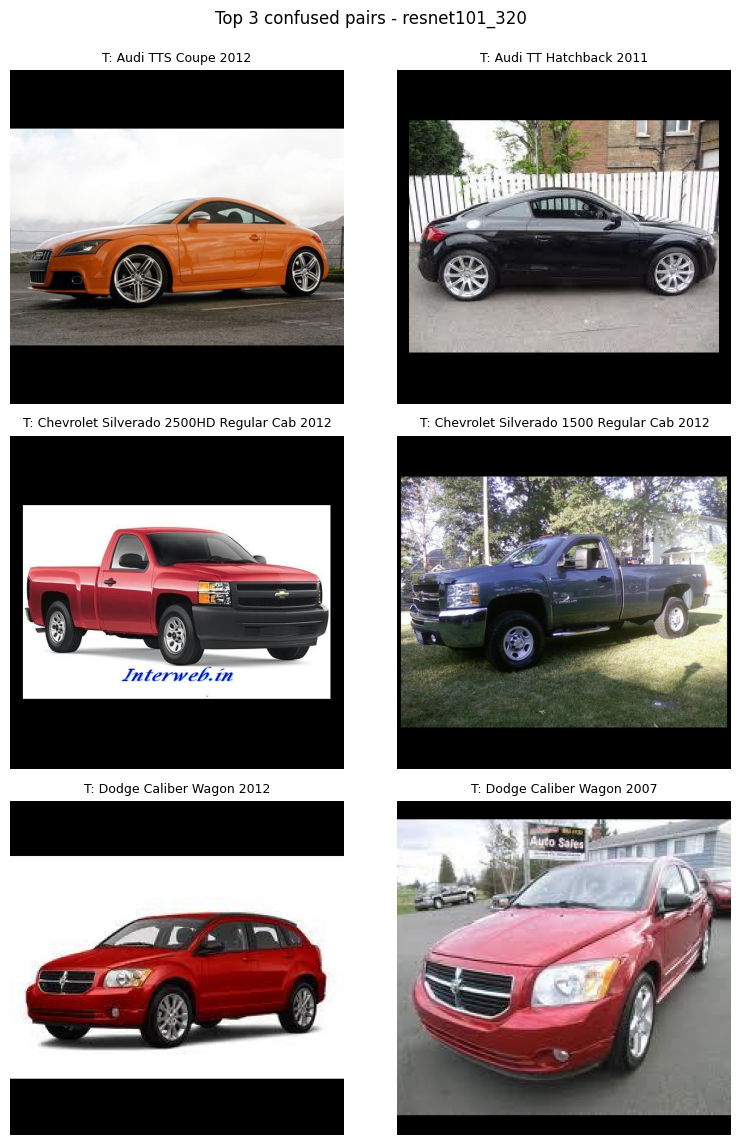

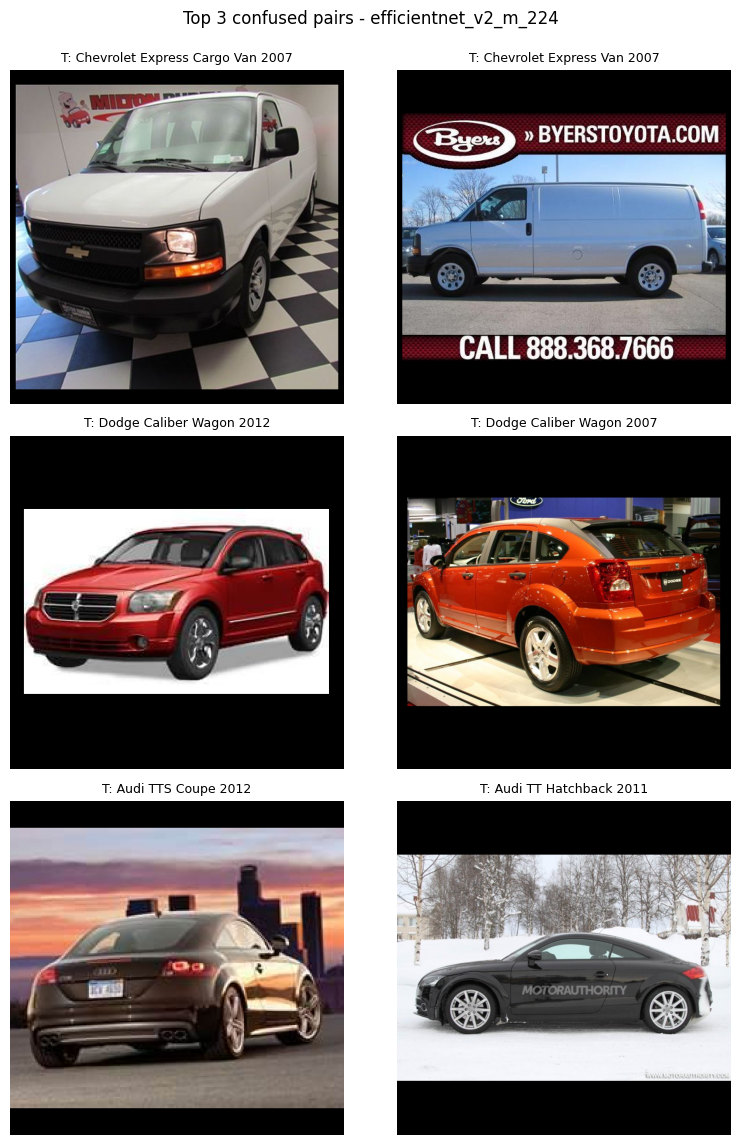

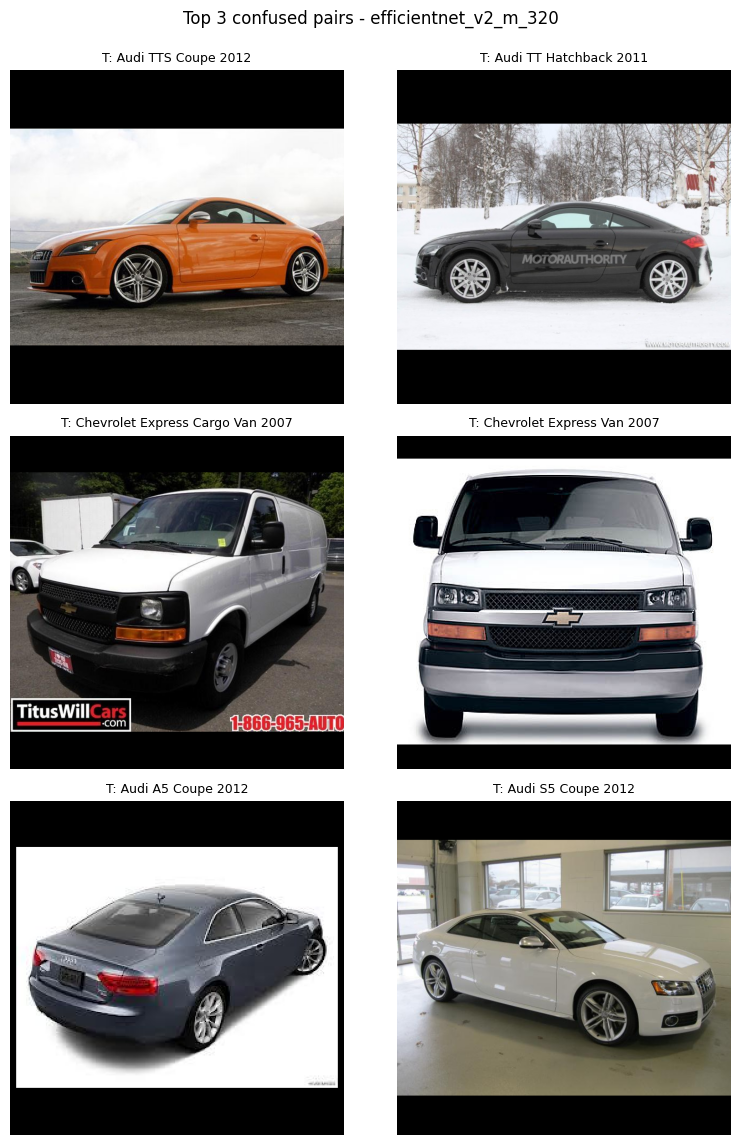

In [8]:
# Top-3 misclassified pairs with one figure per model
from cars_dataset import CarsCsvDataset

for _, res in inference_cache.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    run_name = res['run_name']
    test_files = res['test_files']
    test_boxes = res['test_boxes']
    test_labels = res['test_labels']

    test_ds_show = CarsCsvDataset(
        test_files, test_boxes, test_labels, transform=None,
        crop_mode="square_from_full", square_margin=0.10
    )

    mask = y_true != y_pred
    pairs = pd.DataFrame({'a': y_true[mask], 'b': y_pred[mask]})
    pairs[['u', 'v']] = np.sort(pairs[['a', 'b']].values, axis=1)

    pair_counts = (
        pairs.groupby(['u', 'v']).size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
    )

    top3 = pair_counts.head(3)

    n = len(top3)
    fig, axes = plt.subplots(n, 2, figsize=(8, 4 * n))
    if n == 1:
        axes = [axes]
    fig.suptitle(f"Top 3 confused pairs - {run_name}", y=0.95)

    for i, (_, row) in enumerate(top3.iterrows()):
        u = int(row['u'])
        v = int(row['v'])
        u_name = id_to_name.get(u + 1, str(u))
        v_name = id_to_name.get(v + 1, str(v))

        idx_uv = np.where((y_true == u) & (y_pred == v))[0]
        idx_vu = np.where((y_true == v) & (y_pred == u))[0]

        if len(idx_uv) == 0 and len(idx_vu) == 0:
            continue

        left_idx = int(idx_uv[0]) if len(idx_uv) else int(idx_vu[0])
        right_idx = int(idx_vu[0]) if len(idx_vu) else int(idx_uv[0])

        ax_left, ax_right = axes[i]
        img, _ = test_ds_show[left_idx]
        img_np = img.permute(1, 2, 0).numpy()
        ax_left.imshow(img_np)
        ax_left.set_title(f"T: {u_name}", fontsize=9, pad=6)
        ax_left.axis("off")

        img, _ = test_ds_show[right_idx]
        img_np = img.permute(1, 2, 0).numpy()
        ax_right.imshow(img_np)
        ax_right.set_title(f"T: {v_name}", fontsize=9, pad=6)
        ax_right.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()


100%|██████████| 48/48 [00:04<00:00, 10.82it/s]


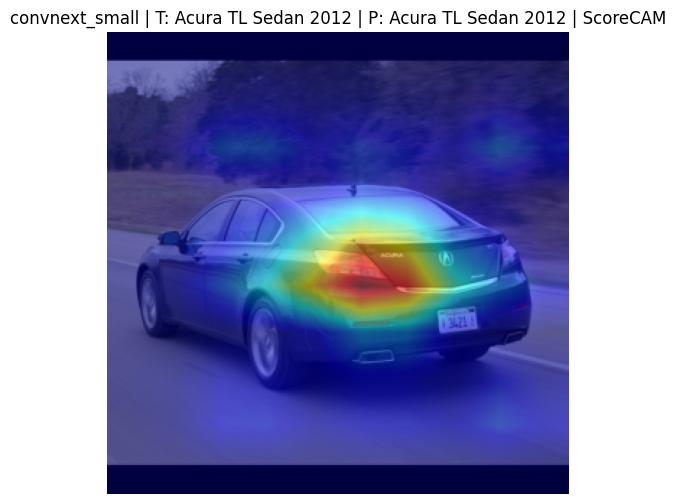

100%|██████████| 128/128 [00:05<00:00, 22.21it/s]


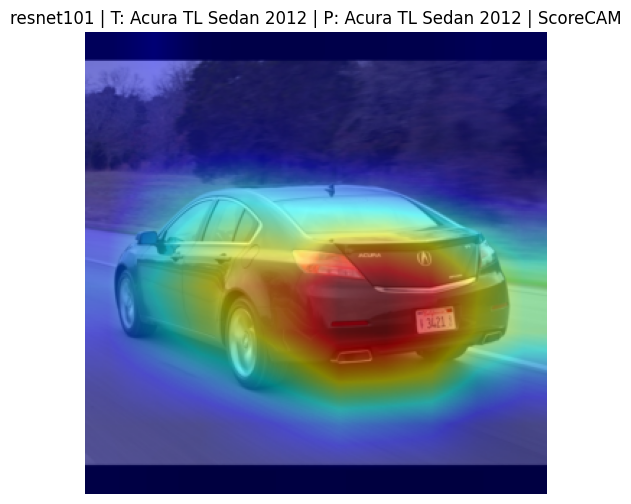

100%|██████████| 80/80 [00:04<00:00, 16.11it/s]


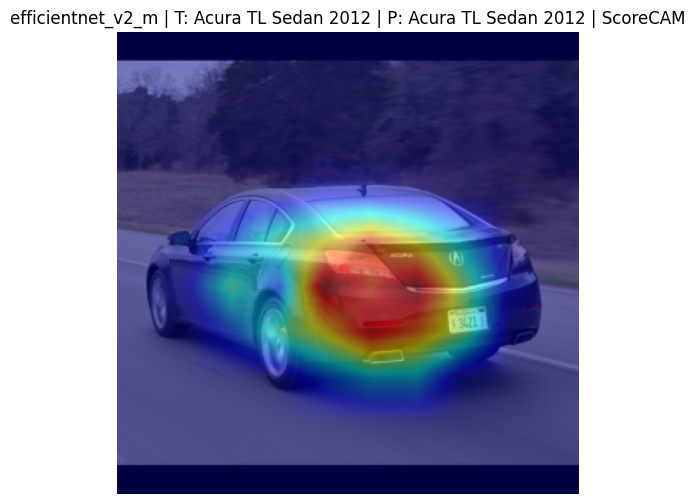

In [9]:
# Score-CAM (or other CAM) for a single test image: one figure per model
# (No testing/occlusion; consistent figure sizes)

import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from data_utils import df_to_arrays, get_mean_std_from_weights

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# -----------------------
# Settings
# -----------------------
gradcam_idx = 42
gradcam_res = 320
CAM_METHOD = ScoreCAM          # GradCAM, GradCAMPlusPlus, ScoreCAM
FIGSIZE = (6, 6)               # all figures will use this size
SHOW_RAW_CAM = False            # set False if you only want the overlay

test_files, test_boxes, test_labels = df_to_arrays(test_df)


def tensor_to_img(x, mean, std):
    # De-normalize a [1,3,H,W] tensor to an RGB float image [H,W,3] in [0,1].
    mean_t = torch.tensor(mean, device=x.device)[None, :, None, None]
    std_t = torch.tensor(std, device=x.device)[None, :, None, None]
    img = (x * std_t + mean_t).clamp(0, 1)
    return img[0].permute(1, 2, 0).detach().cpu().numpy().astype(np.float32)


def get_target_layers(model, model_key: str):
    # Pick a sane target layer for torchvision-style models.
    if model_key == "convnext_small":
        return [model.features[7][-1].block[0]]   # last stage, last block, depthwise conv
    if model_key == "resnet101":
        return [model.layer4[-1]]                 # last residual block
    if model_key == "efficientnet_v2_m":
        return [model.features[-1]]               # last feature block

    # fallback: last Conv2d
    last = None
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            last = m
    if last is None:
        raise ValueError(f"No Conv2d found for model_key={model_key}")
    return [last]


def run_cam(model, images, target_layers, class_idx: int):
    targets = [ClassifierOutputTarget(class_idx)]
    with CAM_METHOD(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=images, targets=targets)  # [N,H,W] in [0,1]
    return grayscale_cam[0]


for spec in model_specs:
    weights = spec["weights"]
    mean, std = get_mean_std_from_weights(weights)

    # dataset + one sample
    test_tfms = build_test_transforms(gradcam_res, weights)
    test_ds = CarsCsvDataset(
        test_files, test_boxes, test_labels, transform=test_tfms,
        crop_mode="square_from_full", square_margin=0.10
    )

    image, label = test_ds[gradcam_idx]
    images = image.unsqueeze(0).to(device)

    # model + checkpoint
    model = build_model(spec["model_key"], weights).to(device)
    run_name = f"{spec['ckpt_prefix']}_{gradcam_res}"
    ckpt_path = os.path.join(cfg.save_dir, f"{run_name}_best.pth")
    ckpt = torch.load(ckpt_path, map_location=device)
    state = ckpt.get("model", ckpt)
    model.load_state_dict(state)
    model.eval()

    # predicted class
    with torch.no_grad():
        logits = model(images)
    pred_idx = int(logits.argmax(dim=1).item())
    true_idx = int(label)

    true_name = id_to_name.get(true_idx + 1, str(true_idx))
    pred_name = id_to_name.get(pred_idx + 1, str(pred_idx))

    # CAM
    target_layers = get_target_layers(model, spec["model_key"])
    cam_map = run_cam(model, images, target_layers, class_idx=pred_idx)

    # Overlay visualization
    img_np = tensor_to_img(images, mean, std)  # [H,W,3] float32 in [0,1]
    vis = show_cam_on_image(img_np, cam_map, use_rgb=True)

    plt.figure(figsize=FIGSIZE)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{spec['model_key']} | T: {true_name} | P: {pred_name} | {CAM_METHOD.__name__}")
    plt.show()

    if SHOW_RAW_CAM:
        plt.figure(figsize=FIGSIZE)
        plt.imshow(cam_map, cmap="jet")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")
        plt.title(f"Raw CAM | {spec['model_key']} | {CAM_METHOD.__name__}")
        plt.show()

    del model
    torch.cuda.empty_cache()
